In [1]:
# Setup
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import numpy as np
import pandas as pd
import datetime as dt

# SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, asc

In [3]:
# Create engine to hawaii.sqlite

engine = create_engine("sqlite:///data/hawaii.sqlite")

In [4]:
# Reflect an existing database into a new model

Base = automap_base()

# Reflect the tables

Base.prepare(autoload_with=engine)

In [5]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table

Station = Base.classes.station
Measurement = Base.classes.measurement

In [7]:
# Create session link from Python to the DB

session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.

recent_date_row = session.query(Measurement.date).order_by(desc(Measurement.date)).first()
recent_date = dt.datetime.strptime(recent_date_row[0], '%Y-%m-%d')
recent_date

datetime.datetime(2017, 8, 23, 0, 0)

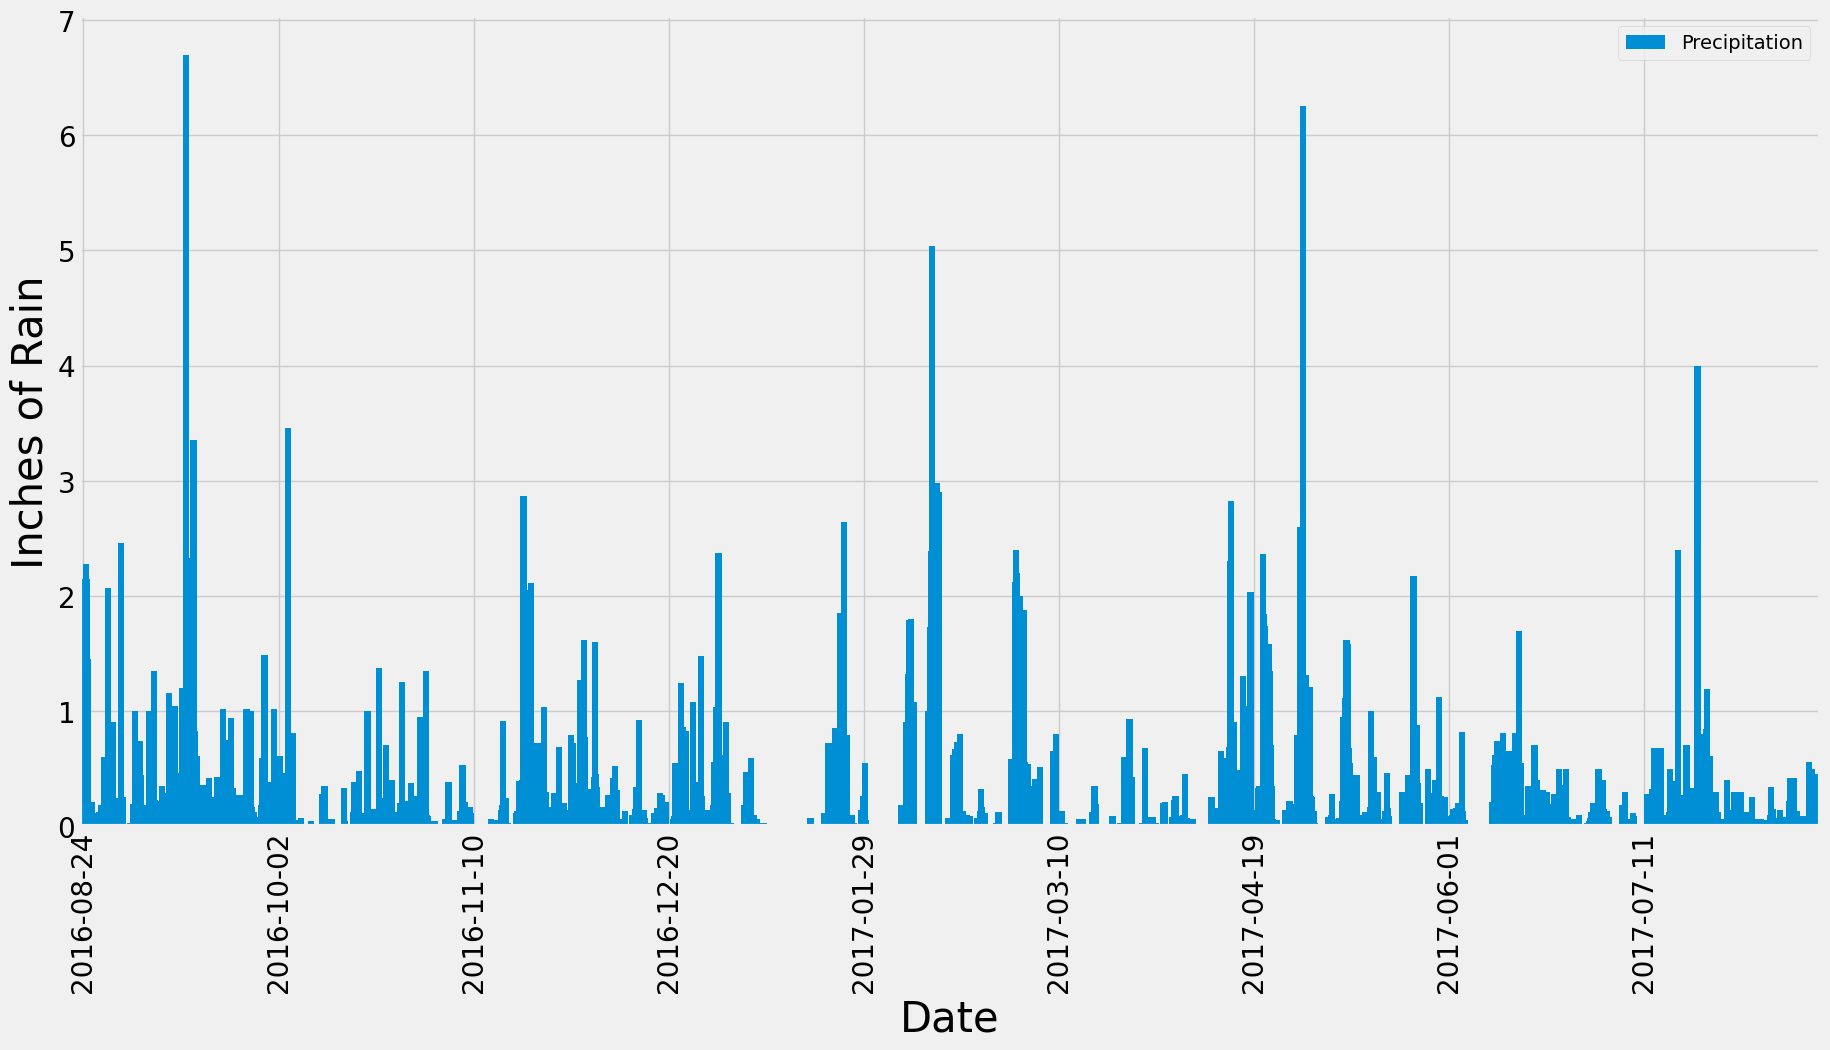

In [22]:
# Retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database (and going back one year from that date) 

past_year = recent_date - dt.timedelta(days=365)

# Retrieve the data and precipitation scores

past_year_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= past_year).all()

# Save query results as a Pandas DataFrame

df = pd.DataFrame()

data = [{
    "Date": r.date,
    "Precipitation": r.prcp
} for r in past_year_data]

df = pd.DataFrame(data)

# Sort the dataframe by date

df = df.sort_values(by="Date", ascending=True)

# Plot the data

ax = df.plot(x="Date", y="Precipitation", kind="bar", figsize=(20, 10), width=8, fontsize=20)
ax = ax.xaxis.set_major_locator(MaxNLocator(nbins=9))

plt.ylabel("Inches of Rain", fontsize=30)
plt.xlabel("Date", fontsize=30)

plt.savefig("visuals/precipitation.png", bbox_inches="tight", transparent=True)
plt.show()

In [10]:
# Calculate the summary statistics

df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [11]:
# Calculate the total number of stations in the dataset
stations = session.query(func.count(func.distinct(Measurement.station))).scalar()
stations

9

In [12]:
# Find the most active stations, listed in descending order
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Calculate the lowest, highest, and average temperature for the most active station

most_active = active_stations[0]
active_station = most_active[0]
active_station

lowest_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == active_station).\
    order_by(asc(Measurement.tobs)).first()
lowest_temp = lowest_temp[0]

highest_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == active_station).\
    order_by(desc(Measurement.tobs)).first()
highest_temp = highest_temp[0]

avg_temp = session.query(Measurement.tobs, func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_station).scalar()

# Print findings

print(f"Station {active_station} Temperature Stats:")
print(f"Lowest temperature: {lowest_temp} degrees F.")
print(f"Highest temperature: {highest_temp} degrees F.")
print(f"Average temperature: {avg_temp} degrees F.")

Station USC00519281 Temperature Stats:
Lowest temperature: 54.0 degrees F.
Highest temperature: 85.0 degrees F.
Average temperature: 70.0 degrees F.


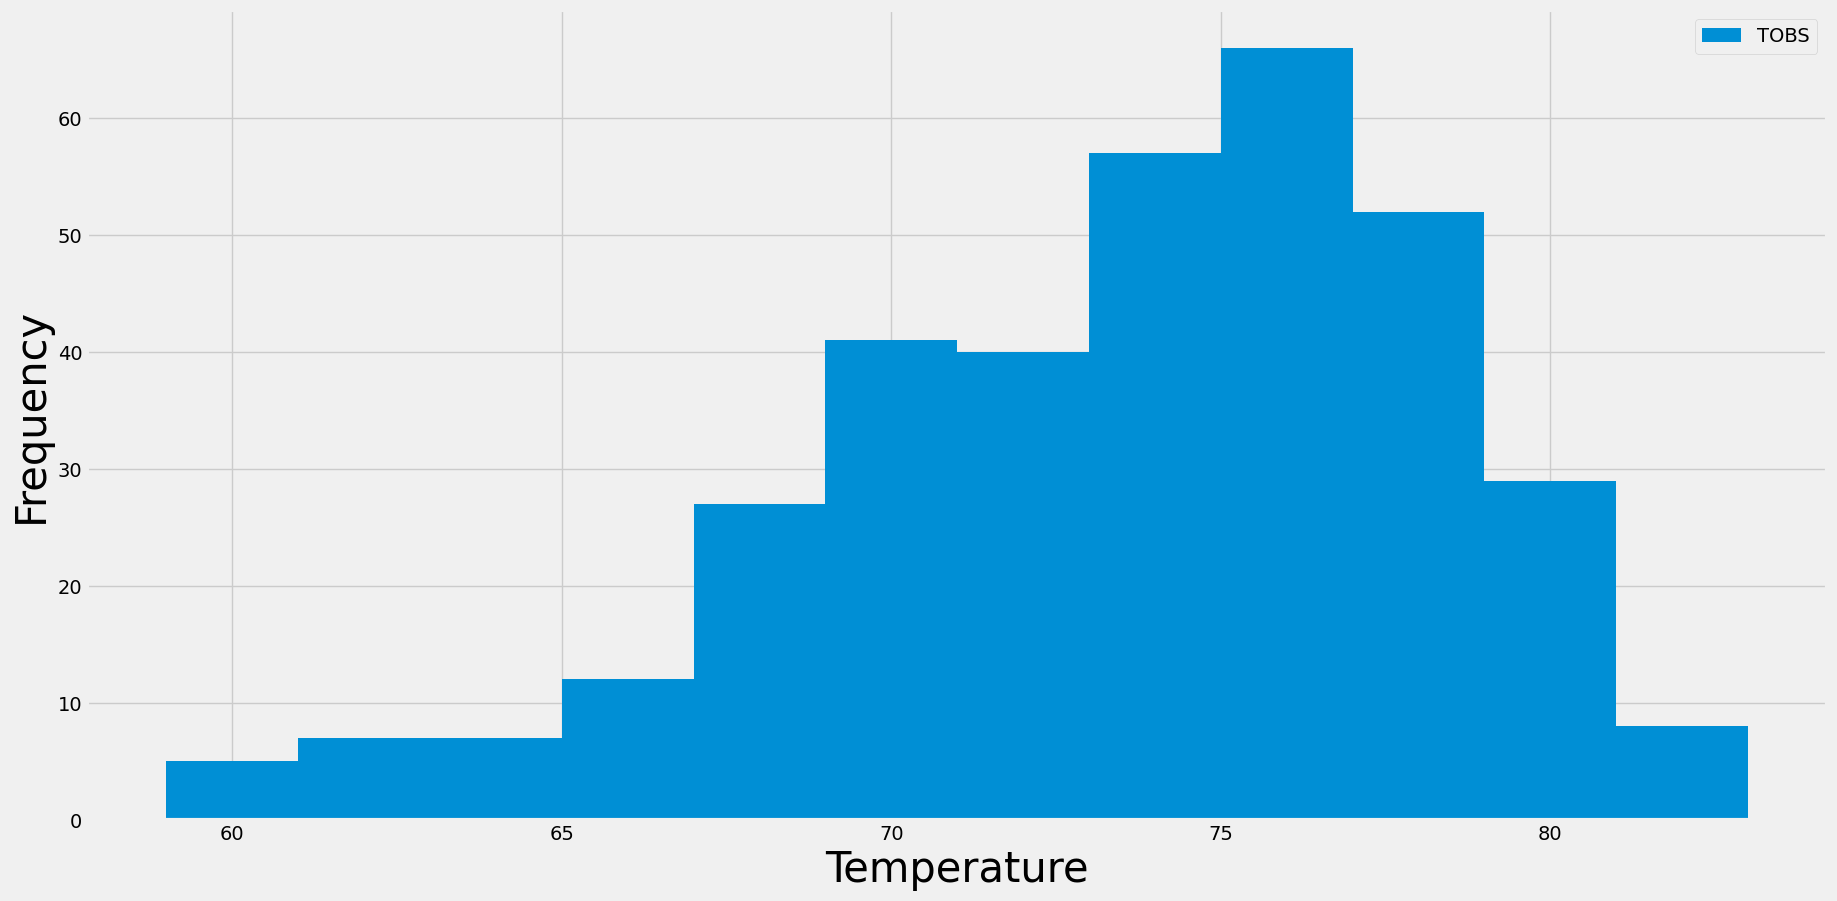

In [21]:
# Query the last 12 months of temperature observation data for the most active station
# Plot the results as a histogram

temp_data_query = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == active_station).\
    filter(Measurement.date >= past_year).all()

temp_df = pd.DataFrame()

temp_data = ({
    "Date": r.date,
    "TOBS": r.tobs
} for r in temp_data_query)

temp_df = pd.DataFrame(temp_data)

ax = temp_df.plot(x="Date", y="TOBS", kind="hist", bins=12, figsize=(20, 10))

plt.xlabel("Temperature", fontsize=30)
plt.ylabel("Frequency", fontsize=30)

plt.savefig("visuals/tobs.png", bbox_inches="tight", transparent=True)
plt.show()

# Close Session

In [15]:
# Close Session
session.close()